In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import random
import time

# IA - Labyrinth

In [2]:
def generate_labyrinth(width, height, wall_ratio=0.3):
    """ Randomly generates the labyrinth matrix, the values are:
    0 if the cell is free
    1 if there is a wall
    :param width int: width of the matrix
    :param height int: height of the matrix
    :wall_ratio float: chance for a cell to be a wall
    :return: tuple composed of:
    <matrix>: numpy 2d array
    <start_cell>: tuple of i, j indices for the start cell
    <end_cell>: tuple of i, j indices for the end cell
    """
    grid = np.random.rand(width, height)
    grid[grid >= 1 - wall_ratio] = 1
    grid[grid < 1 - wall_ratio] = 0
    free_cell_top = [i for i in range(0, width) if grid[0][i] != 1]
    start_idx = random.choice(free_cell_top)
    start_cell = (0, start_idx)
    free_cell_bottom = [i for i in range(0, width) if grid[-1][i] != 1]
    end_idx = random.choice(free_cell_bottom)
    end_cell = (height - 1, end_idx)
    return grid, start_cell, end_cell

In [3]:
def display_labyrinth(grid, start_cell, end_cell, solution=None):
    """ Display the labyrinth matrix and possibly the solution with matplotlib.
    Free cell will be in light gray.
    Wall cells will be in dark gray.
    Start and end cells will be in dark blue.
    Path cells (start, end excluded) will be in light blue.
    :param grid np.array: labyrinth matrix
    :param start_cell: tuple of i, j indices for the start cell
    :param end_cell: tuple of i, j indices for the end cell
    :param solution: list of successive tuple i, j indices who forms the path
    """
    grid = np.array(grid, copy=True)
    FREE_CELL = 19
    WALL_CELL = 16
    START = 0
    END = 0
    PATH = 2
    grid[grid == 0] = FREE_CELL
    grid[grid == 1] = WALL_CELL
    grid[start_cell] = START
    grid[end_cell] = END
    if solution:
        solution = solution[1:-1]
        for cell in solution:
            grid[cell] = PATH
    else:
        print("No solution has been found")
    plt.matshow(grid, cmap="tab20c")

In [43]:
MAZE_SIZE = 10
grid, start_cell, end_cell = generate_labyrinth(MAZE_SIZE, MAZE_SIZE)

In [58]:
def load_grid(grid_file):
    grid = np.load(grid_file)
    h = grid.shape[0]
    w = grid.shape[1]
    return (grid, (h, w))

grid, size = load_grid("grids/grid10.npy")
start_cell = (0,0)
end_cell = (size[0]-1,size[1]-1)

No solution has been found


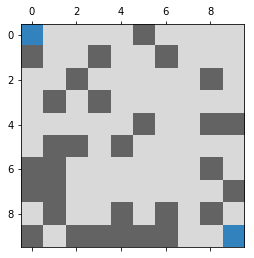

In [59]:
display_labyrinth(grid, start_cell, end_cell)

In [7]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms
import operator
from enum import Enum
from collections import namedtuple
import random
import time

# Data Structure

In [95]:
# Each operand or operator is described by 4 bits
CODE_LENGTH = 4

# In this example, we fix the number of directions to 4
NB_DIRECTIONS = 4

CHROMOSOME_LENGTH_START = (size[0]+size[1])

# We have three type of code: operands, operators and undefined symbols
class CodeType(Enum):
    DIRECTION = 1
    NOTHING = 2

# namedtuple("typename, field_names[...]") returns a new tuple subclass named 'typename'. 
# The new subclass is used to create tuple-like objects that have fields accessible 
# by attribute lookup as well as being indexable and iterable
Code = namedtuple("Code", ["code_type", "apply", "str"])

class Direction(Enum):
    TOP = 0#, "t", np.array([-1, 0]))
    RIGHT = 1#, "r", np.array([0, 1]))
    BOTTOM = 2#, "b", np.array([1, 0]))
    LEFT = 3#, "l", np.array([0, -1]))
    
    def apply(self, location):
        return location + self.move
    
    def to_str(self):
        self.string
    
    def get_move(self):
        return self._tbl[self]

Direction._tbl = {
    Direction.TOP:   np.array([-1, 0]),
    Direction.RIGHT: np.array([0, 1]),
    Direction.BOTTOM:   np.array([1, 0]),
    Direction.LEFT: np.array([0, -1])
}

## Generic tools

In [100]:
def available_direction(location, previous_direction = None):
    directions = set()
    #for direction in Direction:
    #    print(shake)
    if(location[0] > 0 and grid[tuple(location+Direction.TOP.get_move())] != 1.0):
        directions.add(Direction.TOP)
    if(location[0] < size[0]-1 and grid[tuple(location+Direction.BOTTOM.get_move())] != 1.0):
        directions.add(Direction.BOTTOM)
    if(location[1] > 0 and grid[tuple(location+Direction.LEFT.get_move())] != 1.0):
        directions.add(Direction.LEFT)
    if(location[1] < size[1]-1 and grid[tuple(location+Direction.RIGHT.get_move())] != 1.0):
        directions.add(Direction.RIGHT)
    
    if(len(directions)>1 and previous_direction):
        directions.discard(previous_direction)
    
    return directions

## Deap Framework

In [ ]:
toolbox = base.Toolbox()

### Fitnesse

In [70]:
def fitness(individual, target):
    return (abs(compute_chromosome(individual) - target),) # Tuple !
toolbox.register("fitness", fitness)

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

NameError: name 'toolbox' is not defined

A prendre en compte: 
    -Validité chemin
    - Intégrité
    - Qualité
    - Des approche
    - Temps

### Create Individuals

In [22]:
creator.create("Individual", list, fitness=creator.FitnessMin) 

AttributeError: module 'deap.creator' has no attribute 'FitnessMin'

200
No solution has been found


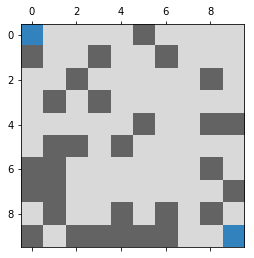

In [66]:
print(CHROMOSOME_LENGTH_START)
display_labyrinth(grid, start_cell, end_cell)

[<Direction.RIGHT: 1>, <Direction.RIGHT: 1>, <Direction.RIGHT: 1>, <Direction.RIGHT: 1>, <Direction.BOTTOM: 2>, <Direction.BOTTOM: 2>, <Direction.RIGHT: 1>, <Direction.TOP: 0>, <Direction.LEFT: 3>, <Direction.BOTTOM: 2>, <Direction.LEFT: 3>, <Direction.RIGHT: 1>, <Direction.RIGHT: 1>, <Direction.BOTTOM: 2>, <Direction.LEFT: 3>, <Direction.BOTTOM: 2>, <Direction.LEFT: 3>, <Direction.LEFT: 3>, <Direction.LEFT: 3>, <Direction.LEFT: 3>]


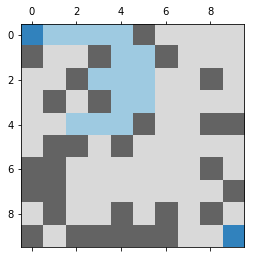

In [140]:
start_location = np.array([0, 0])
def init_individual():
    individual = []
    locations = []
    
    location = start_location
    previous_direction = None
    
    for i in range(0,CHROMOSOME_LENGTH_START):
        directions = available_direction(location, previous_direction)
        #print(directions)
        direction = random.sample(directions,1)[0]
        #print(direction)
        individual.append(direction)
        locations.append(tuple(location))
        
        location = location + direction.get_move()
        previous_direction = Direction((direction.value+2)%4)
    return individual, locations
ind, locations = init_individual()
print(ind)
display_labyrinth(grid, start_cell, end_cell, locations)

In [ ]:
toolbox.register("init_gene", random.randint, 0, len(Direction))


toolbox.register("init_individual", tools.initRepeat, creator.Individual, toolbox.init_gene, CHROMOSOME_LENGTH_START)
toolbox.register("init_population", tools.initRepeat, list, toolbox.init_individual)

### Crossover

In [ ]:
update after cross over

In [ ]:
- recursive

### Mutation

In [ ]:
Ne pas revenir en arrière
Probabilité de mutation identique partout ?
- récursive

## Main

## Interface

In [ ]:
def solve_labyrinth(grid, start_cell, end_cell, max_time_s):
    """ Attempt to solve the labyrinth by returning the best path found
    :param grid np.array: numpy 2d array
    :start_cell tuple: tuple of i, j indices for the start cell
    :end_cell tuple: tuple of i, j indices for the end cell
    :max_time_s float: maximum time for running the algorithm
    :return list: list of successive tuple i, j indices who forms the path
    """
    start_time = inter_time = time.time()
    population = toolbox.init_population(n=10)

    # crossover probability
    CXPB = 0.7

    # mutation probability (of a chromosome)
    # compare with the indpb=0.1 in the previous line toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
    MUTPB = 0.2

    evaluate_population(population, TARGET)
    solution = None

    number_of_iterations = 0
    while len(find_winners(population)) == 0 and inter_time - start_time < max_time_s:
        children = toolbox.select(population, len(population))

        # Full alternative ---
        # Clone the selected individuals, 
        # TODO: test your code without the cloning, print the 
        children = list(map(toolbox.clone, children))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(children[::2], children[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)            

        for mutant in children:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)

        # ---

        # Shorcut alternative ---
        #children = algorithms.varAnd(offspring, toolbox, 0.7, 0.2)
        # ---

        evaluate_population(children, TARGET)
        population = children

        # Search for the solution
        fitnesses = [ind.fitness.values[0] for ind in population]
        min_fit = min(fitnesses)
        best = population[fitnesses.index(min_fit)]
        if not solution or best.fitness.values[0] < solution.fitness.values[0]:
            solution = best

        inter_time = time.time()

        number_of_iterations += 1

    duration = time.time() - start_time

    # TODO 4 :) In which case the following line is execuded?
    if not solution:
        solution = find_winners(population)[0]
    
    display_labyrinth(grid, start_cell, end_cell, solution)

In [ ]:
grid, size = load_grid("grids/grid10.npy")
start_cell = np.array([0,0])
end_cell = (size[0]-1,size[1]-1)
max_time_s = 5

solve_labyrinth(grid, start_cell, end_cell, max_time_s)